

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Lunar Lander**




##Libraries

In [ ]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [ ]:
import gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random

## Hyperparameters

In [ ]:
GAMMA = 0.99
MEMORY_SIZE = 100000
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995
NUMBER_OF_EPISODES = 300
MAX_STEPS = 500
SYNC_TARGET_WEIGHTS = 100

## Class ReplayMemory

Memory of transitions for experience replay.

In [ ]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]
        terminal_states = self.terminal_states[batch]
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [ ]:
def build_dqn(lr,number_of_actions,number_of_observations):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(100, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
  model.add(keras.layers.Dense(100, activation="relu",kernel_initializer="he_normal"))
  model.add(keras.layers.Dense(number_of_actions, activation="linear"))
  model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

  return model



class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX #epsilon
        self.number_of_actions = number_of_actions #number of possible actions by lander
        self.number_of_observations = number_of_observations # number of factors in the state; e.g: velocity, position, etc
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.q_eval = build_dqn(LEARNING_RATE,number_of_actions,number_of_observations)
        self.q_target = build_dqn(LEARNING_RATE,number_of_actions,number_of_observations)

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy In other words, with the probability epsilon (passed as an argument),
        #we take the random action; otherwise, we use the past model to obtain the Q-values for all possible actions and choose the best.
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.q_eval.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        #Double DQN Loss function
        q_targets = self.q_eval.predict(states, verbose=0)
        q_next_states = self.q_target.predict(next_states, verbose=0)
        q_eval = self.q_eval.predict(next_states,verbose=0)

        max_actions = [np.argmax(i) for i in q_eval]


        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:

                  q_targets[i][actions[i]] = rewards[i] + GAMMA * q_next_states[i][max_actions[i]]

        self.q_eval.train_on_batch(states, q_targets)



        # Decrease exploration rate
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

        #Update target weights
        if self.memory.current_size % SYNC_TARGET_WEIGHTS:
          self.update_network_parameters()


    def update_network_parameters(self):
        self.q_target.set_weights(self.q_eval.get_weights())

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")



In [ ]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Main program




/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode   1: score  75 (exploration rate: 0.94, transitions: 75)
Episode   2: score  84 (exploration rate: 0.62, transitions: 159)
Episode   3: score 211 (exploration rate: 0.21, transitions: 370)
Episode   4: score  86 (exploration rate: 0.14, transitions: 456)
Episode   5: score  78 (exploration rate: 0.09, transitions: 534)
Episode   6: score  89 (exploration rate: 0.06, transitions: 623)
Episode   7: score 122 (exploration rate: 0.03, transitions: 745)
Episode   8: score 182 (exploration rate: 0.01, transitions: 927)
Episode   9: score  77 (exploration rate: 0.01, transitions: 1004)
Episode  10: score  83 (exploration rate: 0.01, transitions: 1087)
Episode  11: score  78 (exploration rate: 0.01, transitions: 1165)
Episode  12: score 166 (exploration rate: 0.01, transitions: 1331)
Episode  13: score 126 (exploration rate: 0.01, transitions: 1457)
Episode  14: score 118 (exploration rate: 0.01, transitions: 1575)
Episode  15: score 184 (exploration rate: 0.01, transitions: 1759)
Epis

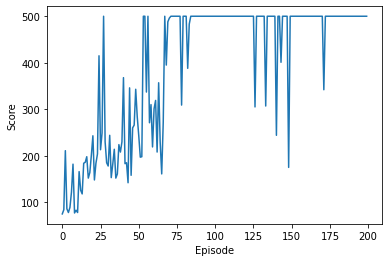

In [ ]:
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
goal_reached = False
start_time = time.perf_counter()
while (episode < 200) :
    episode += 1
    step = 1
    end_episode = False
    state = environment.reset()
    while not(end_episode):
        # Select an action for the current state

        action = agent.select(state)

        # Execute the action in the environment
        state_next, reward, terminal_state, info = environment.step(action)

        # Store in memory the transition (s,a,r,s')
        agent.remember(state, action, reward, state_next, terminal_state)

        # Learn using a batch of experience stored in memory
        agent.learn()

        # Detect end of episode and print
        if terminal_state or step >= MAX_STEPS:
            agent.add_score(step)
            if step >= MAX_STEPS: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(step), end = '')
            print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
            print("transitions: " + str(agent.memory.current_size) + ")")
            end_episode = True
        else:
            state = state_next
            step += 1


if goal_reached: print("Reached goal sucessfully.")
else: print("Failure to reach the goal.")

print ("Time:", round((time.perf_counter() - start_time)/60), "minutes")

agent.display_scores_graphically()

### Mejoras Implementadas

A continuación explicaremos los cambios que hemos realizado para adecuar el código del CarPole al entorno Lunar Lander.
En primer lugar, hemos importado el entorno 'Lunar Lander' de la libreria gym.

Hemos cambiado el número de capas utilizado por la red DQ a 150, el learning rate a 0,0001 y el batch size a 64.

El siguiente paso en el código para implementar la red target. Para ello, hemos añadido un nuevo atributo a la clase DQN, llamado q_target, que toma un modelo identico al de la red inicial. Para simplificar el codigo, hemos creado una función build_dqn, que genera el modelo.

La última mejora que hemos hecho ha sido cambiar la función de pérdida, siguiendo el método Double DQN. La propuesta de este cambio se encuentra en el paper de Silver et al., donde se intenta minimizar el sesgo introducido al calcular el target con el máximo valor de Q.

image_2023-01-11_230047664.png

La nueva funcion de perdida que se propone sigue la siguiente formula

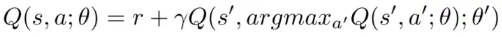

Primero la red neuronal principal decide cuál es la mejor acción entre todas las posibles, y luego la red target evalúa esa acción para conocer su valor-Q.